In [1]:
#Libraries

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(123)

import random
random.seed(123)

#for zero shot learning and LLM data generation
from transformers import set_seed
set_seed(42)

In [2]:
# path_out_ = r'/Users/maelys/Desktop/BSE/Term2/AdvancedNLP/AdvNLP_final_project/view_outputs/'

# path_models_ = r'/Users/maelys/Desktop/BSE/Term2/AdvancedNLP/project_saved_models/'

path_out_ = r'C:/Users/mhand/Documents/D S D M/AdvNLP/final/view_outputs/'

path_models_ = r'C:/Users/mhand/Documents/D S D M/AdvNLP/final/project_saved_models/'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class Metrics:
    def __init__(self):
        self.num_classes = None
        self.results = {}
        self.labels = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
        self.colors = ['#66b3ff', '#ffa500', '#ff99cc', '#ff6666', '#c2c2f0', '#99ff99']

    def run(self, y_true, y_pred, method_name, average='macro'):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        if self.num_classes is None:
            self.num_classes = len(np.unique(y_true))

        # Calculate metrics for each class
        for label in range(self.num_classes):
            y_true_label = (y_true == label).astype(int)
            y_pred_label = (y_pred == label).astype(int)
            accuracy = accuracy_score(y_true_label, y_pred_label)
            precision = precision_score(y_true_label, y_pred_label, zero_division=0)
            recall = recall_score(y_true_label, y_pred_label, zero_division=0)
            f1 = f1_score(y_true_label, y_pred_label, zero_division=0)

            # Store results
            if label not in self.results:
                self.results[label] = {}
            if method_name not in self.results[label]:
                self.results[label][method_name] = {}
            self.results[label][method_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
            }

        # Calculate overall metrics
        overall_accuracy = accuracy_score(y_true, y_pred)
        overall_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        overall_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
        overall_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

        # Store overall results
        if 'Overall' not in self.results:
            self.results['Overall'] = {}
        if method_name not in self.results['Overall']:
            self.results['Overall'][method_name] = {}
        self.results['Overall'][method_name] = {
            'accuracy': overall_accuracy,
            'precision': overall_precision,
            'recall': overall_recall,
            'f1': overall_f1,
        }
        

    def plot_val(self):
        # Create subplots
        fig, axs = plt.subplots(self.num_classes + 1, 4, figsize=(15, 3*(self.num_classes + 1)))

        # Plot each metric for each class
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            for j in range(self.num_classes):
                ax = axs[j, i]
                values = [res[metric] * 100 for res in self.results[j].values()]
                ax.bar(self.results[j].keys(), values, color=self.colors[j])
                ax.set_title(f"{metric} - {self.labels[j]}")
                ax.set_ylim(0, 100)
                ax.set_xticklabels(self.results[j].keys(), rotation=45)

                # Add values on the bars
                for k, v in enumerate(values):
                    ax.text(k, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

            # Plot overall metrics
            ax = axs[-1, i]
            if 'Overall' in self.results:
                values = [res[metric] * 100 for res in self.results['Overall'].values()]
                ax.bar(self.results['Overall'].keys(), values, color='black')
                ax.set_title(f"{metric} - Overall")
                ax.set_ylim(0, 100)
                ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)
                # Add values on the bars
                for k, v in enumerate(values):
                    ax.text(k, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def plot(self):
        fig, axs = plt.subplots(1, 4, figsize=(15, 3))

        # Plot overall metrics
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            values = [res[metric] * 100 for res in self.results['Overall'].values()]
            axs[i].bar(self.results['Overall'].keys(), values, color='black')
            axs[i].set_title(f"{metric} - Overall")
            axs[i].set_ylim(0, 100)
            axs[i].set_xticklabels(self.results['Overall'].keys(), rotation=45)
            # Add values on the bars
            for k, v in enumerate(values):
                axs[i].text(k, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

In [4]:
from datasets import load_dataset

#load data into programming environment
dataset = load_dataset("dair-ai/emotion", trust_remote_code=True)

#three datasets: one training (16000 rows), one validation (2000 rows), one test (2000 rows)
#each have two columns ['text','label']
print("Datasets imported in:", dataset.keys())

df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: ee9ce969-e6d6-4fbc-b8d5-00741d49a671)')' thrown while requesting GET https://huggingface.co/datasets/dair-ai/emotion/resolve/main/emotion.py
Retrying in 1s [Retry 1/5].


Datasets imported in: dict_keys(['train', 'validation', 'test'])


### 4.a Model Distillation
*Distill your best-performing model into a lighter model. Document the process and tools used.*

We want to compress a "teacher" model into a smaller "student" model that will simultaneously be trained to minimize loss but also to learn the weights of the teacher. In order to do that we have created a class called Distillation that is:

- Initialized with the checkpoints of the teacher and student models, the number of labels, optimizer for the training of the student model, and paths to already existing weights.

- It has functions to prepare the data for the training:
    - Prepare data : returns X_train as an array and y_train as one-hot encoded labels
    - Get_batches : Uses the batch_encode_plus function of the tokenizer to add special tokens ([CLS], [SEP]), truncate sentences longer than
    max_lenght, and generate attention masks. The data is then shuffled, which improves generalisation.

- Train step: 
    - @tf.function: Improves performance by constructing a tf.types.experimental.PolymorphicFunction (see [link](https://www.tensorflow.org/api_docs/python/tf/function))

    - tf.GradientTape(): Is for differentiation, in this case to do the gradient descent, where the direction of the descent at each step is determined by the gradient of the loss function with respect to the model parameters.

    - Then at each step we get the predictions of the teacher and student models but only the student is in training mode. These are the logits, so the predictions before the softmax activation function is applied to the output.

    - Then we specify a custom loss function made out of two different loss functions:

$$ L=\alpha⋅L_{soft}⋅T^2​+(1−\alpha)⋅L_{hard}​$$

Which is as in this example in this [Keras article](https://keras.io/examples/vision/knowledge_distillation/) and as explained in [Hinton et al (2015)](https://arxiv.org/abs/1503.02531) except that the alpha and (1-alpha) are switched around. Other ways to refer to these losses is as distillation (=soft) loss and student (=hard) loss.

Where:

- Soft loss: Calculated using the Kullback-Leibler Divergence (KL Divergence), a measure of difference between probavbility distributions of the teacher and student models after passing the logits through the softmax function scaled by the temperature parameter (explained below).

- Hard loss: Difference between student predictions and true labels.

And two parameters:

- alpha: The weight given to each of the losses. 0.5 would be equal weight, higher than that gives higher weight to the soft loss in our function. 

- temperature: Is the smoothing of the output distribution. Higher T means a softer distribution. Very high Ts turn the distribution into a uniform distribution (source: Towards Data Science [link](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f))


Hinton et al. (2015) in "Distilling the Knowledge in a Neural Network" write that the soft loss also has to be multiplied by the squared temperature parameter since otherwise choosing different T would change the weights. Regarding the weights they write: *"We found that the best results were generally obtained by using a condiderably lower weight on the second objective function"* (p.3). Following this advice we have tried alphas of 0.75, 0.5 and 0.25 and found that in our specific case it was better to use equal weights. On the MNIST dataset, Hinton et al. try temperatures of 1,2,5 and 10 and find that 2 is best. In our case we tried 2, 5, 10 and 20 found 10 to be the best.
    
The expectation is that the student model will be able to keep most of the accuracy of the teacher model while being less computationally expensive.

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from sklearn.preprocessing import OneHotEncoder
from transformers import TFBertForSequenceClassification, TFDistilBertForSequenceClassification, DistilBertTokenizer

class Distillation:

    def __init__(self, teacher_checkpoint, student_checkpoint, num_labels, optimizer, alpha=0.5, temperature=2.0, path_to_teacher_weights=None, path_to_student_weights=None):
        """
        Initializing class
        
        Args:
            teacher_checkpoint (string): Identifier for the teacher model.
            student_checkpoint (string): Identifier for the student model.
            num_labels (int): Number of unique labels in the target.
            optimizer: Optimization algorithm for the student weights.
            alpha (float): Factor to weight the student and distillation loss.
            temperature (float): Temperature for softening probability distributions.
            path_to_teacher_weights (string, optional): Path to the location of weights of the teacher model.
            path_to_student_weights (string, optional): Path to the location of weights of the student model.
        """
        self.teacher_model = TFBertForSequenceClassification.from_pretrained(teacher_checkpoint, num_labels=num_labels)

        if path_to_teacher_weights:
            self.teacher_model.load_weights(path_to_teacher_weights)
        
        self.student_model = TFDistilBertForSequenceClassification.from_pretrained(student_checkpoint, num_labels=num_labels)
        
        if path_to_student_weights:
            self.student_model.load_weights(path_to_student_weights)

        self.student_tokenizer = DistilBertTokenizer.from_pretrained(student_checkpoint)
        self.optimizer = optimizer
        self.alpha = alpha
        self.temperature = temperature
        self.loss_fn = CategoricalCrossentropy(from_logits=True)
        self.enc = OneHotEncoder(handle_unknown='ignore')

    def prepare_data(self, df_sample):
        """
        Prepare text data and labels for training.

        Args:
            df_sample (pd.DataFrame): DataFrame with text data and labels.

        Returns:
            tuple: Tuple containing X_train and y_train (labels, one-hot encoded).
        """
        y_train = self.enc.fit_transform(np.array(df_sample['label']).reshape(-1, 1)).toarray()
        
        X_train = np.array(df_sample['text'])
        
        return X_train, y_train
    
    def get_batches(self, X_train, y_train, batch_size, max_length):
        inputs = self.student_tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                                          padding='max_length', return_attention_mask=True,
                                                          return_token_type_ids=False, truncation=True,
                                                          return_tensors="np")
        
        input_ids = np.asarray(inputs['input_ids'], dtype='int32')
        attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

        # Shuffle and yield batches
        while True:
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            input_ids_shuffled = input_ids[indices]
            attention_masks_shuffled = attention_masks[indices]
        
            for i in range(0, len(X_train), batch_size):
                yield [input_ids_shuffled[i:i + batch_size], attention_masks_shuffled[i:i + batch_size]], y_train_shuffled[i:i + batch_size]

    @tf.function
    def train_step(self, inputs, labels):
        """
        Executes a single training step for the student model.

        Args:
            inputs: The input data for the model.
            labels: The true labels

        Returns:
            total_loss: The total loss computed for this training step, a combination of hard and soft losses.
        """
        with tf.GradientTape() as tape:
            # Model predictions (logits)
            student_predictions = self.student_model(inputs, training=True)[0]
            teacher_predictions = self.teacher_model(inputs, training=False)[0]

            # Calculate the soft and hard loss
            hard_loss = self.loss_fn(labels, student_predictions)
            soft_loss = KLDivergence()(tf.nn.softmax(teacher_predictions / self.temperature, axis=-1),
                                       tf.nn.softmax(student_predictions / self.temperature, axis=-1))

            total_loss = (self.alpha * soft_loss * (self.temperature ** 2)) + ((1 - self.alpha) * hard_loss)

        gradients = tape.gradient(total_loss, self.student_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student_model.trainable_variables))
        return total_loss
    
    def predict(self, texts, max_length):
        """
        Tokenize input texts and predict using the student model.

        Args:
            texts (list[str]): List of text inputs to predict.
            max_length (int): Maximum length for tokenization.

        Returns:
            np.array: Predicted class indices.
        """
        inputs = self.student_tokenizer.batch_encode_plus(texts,
                                                          add_special_tokens=True,
                                                          max_length=max_length,
                                                          padding='max_length',
                                                          return_attention_mask=True,
                                                          return_token_type_ids=False,
                                                          truncation=True,
                                                          return_tensors="np")

        inputs_data = {'input_ids': np.asarray(inputs['input_ids'], dtype='int32'),
                       'attention_mask': np.asarray(inputs['attention_mask'], dtype='int32')}

        preds = self.student_model.predict(inputs_data)
        preds = np.argmax(preds.logits, axis=1)
        
        return preds
    
    def get_teacher_model(self):
        """
        Returns the teacher model.
        """
        return self.teacher_model

    def get_student_model(self):
        """
        Returns the student model.
        """
        return self.student_model

In [31]:
# Initialization with parameters

distiller = Distillation(
    teacher_checkpoint='bert-base-uncased',
    student_checkpoint='distilbert-base-uncased',
    num_labels=6,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    alpha = 0.5,
    temperature= 10.0,
    path_to_teacher_weights = path_models_ + 'bert_model_weights_100.h5'
)

# Preparing (turning into arrays, one hot encoding y_train)

X_train, y_train = distiller.prepare_data(df_train)
batch_size = 64
max_length = 64

# Turn into batches

batches = distiller.get_batches(X_train, y_train, batch_size, max_length)

# Calculate steps (+1 in case there is remaining data that doesnt fit into one full batch)

steps_per_epoch = len(X_train) // batch_size
if len(X_train) % batch_size != 0:
    steps_per_epoch += 1

num_epochs = 2

for epoch in range(num_epochs):
    step = 0 # step counter for each epoch
    for batch_data, batch_labels in batches:
        loss = distiller.train_step(batch_data, batch_labels)
        print(f'Epoch {epoch+1}, Step {step+1}/{steps_per_epoch}, Loss: {loss.numpy()}')

        step += 1 #counter
        if step >= steps_per_epoch:  # Check if current step = step of epoch
            break  # Exit loop


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you e

Epoch 1, Step 1/250, Loss: 0.990738570690155
Epoch 1, Step 2/250, Loss: 0.9500378966331482
Epoch 1, Step 3/250, Loss: 0.9404858350753784
Epoch 1, Step 4/250, Loss: 0.9090369343757629
Epoch 1, Step 5/250, Loss: 0.8626355528831482
Epoch 1, Step 6/250, Loss: 0.8552356362342834
Epoch 1, Step 7/250, Loss: 0.8689764142036438
Epoch 1, Step 8/250, Loss: 0.8562448620796204
Epoch 1, Step 9/250, Loss: 0.8031641244888306
Epoch 1, Step 10/250, Loss: 0.7811644673347473
Epoch 1, Step 11/250, Loss: 0.8282648324966431
Epoch 1, Step 12/250, Loss: 0.8482271432876587
Epoch 1, Step 13/250, Loss: 0.7901023030281067
Epoch 1, Step 14/250, Loss: 0.8140192031860352
Epoch 1, Step 15/250, Loss: 0.7887516617774963
Epoch 1, Step 16/250, Loss: 0.7712036371231079
Epoch 1, Step 17/250, Loss: 0.8102110624313354
Epoch 1, Step 18/250, Loss: 0.8039373755455017
Epoch 1, Step 19/250, Loss: 0.733486533164978
Epoch 1, Step 20/250, Loss: 0.7008652091026306
Epoch 1, Step 21/250, Loss: 0.7689625024795532
Epoch 1, Step 22/250, Lo

In [32]:
distiller.student_model.save_weights(path_models_ + "bert_model_weights_100_student_05_10.h5")

### 4.b Performance and Speed Comparison
*Evaluate the distilled model's performance and inference speed compared to the original. Highlight key findings.*

We can then initialize a new Distillation class loading the student weights and look at the predictions. Comparing the overall metrics we see:

|| Teacher (Validation/Test)      | Student (Validation / Test) | % Performance (Validation / Test)
|-----| ----------- | ----------- |----------|
|**Accuracy**|   / 93.30    |  93.75 / 93.05  |   x% /  99.73%|
|**Precision**|   / 88.25    |     91.66 / 89.84  |  x% / 101.80%   |
|**Recall**|        / 91.37   |   91.11 /   88.67  |    x% /  97.04%|
|**F1 Score**|       / 89.55   |    91.20 / 89.00   |     x% /  99.39%|

Therefore the student model retains almost the entire predictive capability of the teacher model, even outperforming it slightly in terms of Precision.


|| Teacher      | Student | % of Teacher |
|-----| ----------- | ----------- |----------|
|**Prediction Time**|   ?       |  45s     |   x%   |
|**Num. Parameters**|   109.49 Mil      |   66.96 Mil     |  61.2%     |
|**Size .h5 file**|       427,952 KB     |   261,687 KB      |    61.1%   |
|**Training time ?**|      ?    |         |     x%  |

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you e

63/63 [==============================] - 50s 783ms/step


C:\Users\mhand\AppData\Local\Temp\ipykernel_24308\1775044619.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
C:\Users\mhand\AppData\Local\Temp\ipykernel_24308\1775044619.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
C:\Users\mhand\AppData\Local\Temp\ipykernel_24308\1775044619.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
C:\Users\mhand\AppData\Local\Temp\ipykernel_24308\1775044619.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(self.results[j].keys(

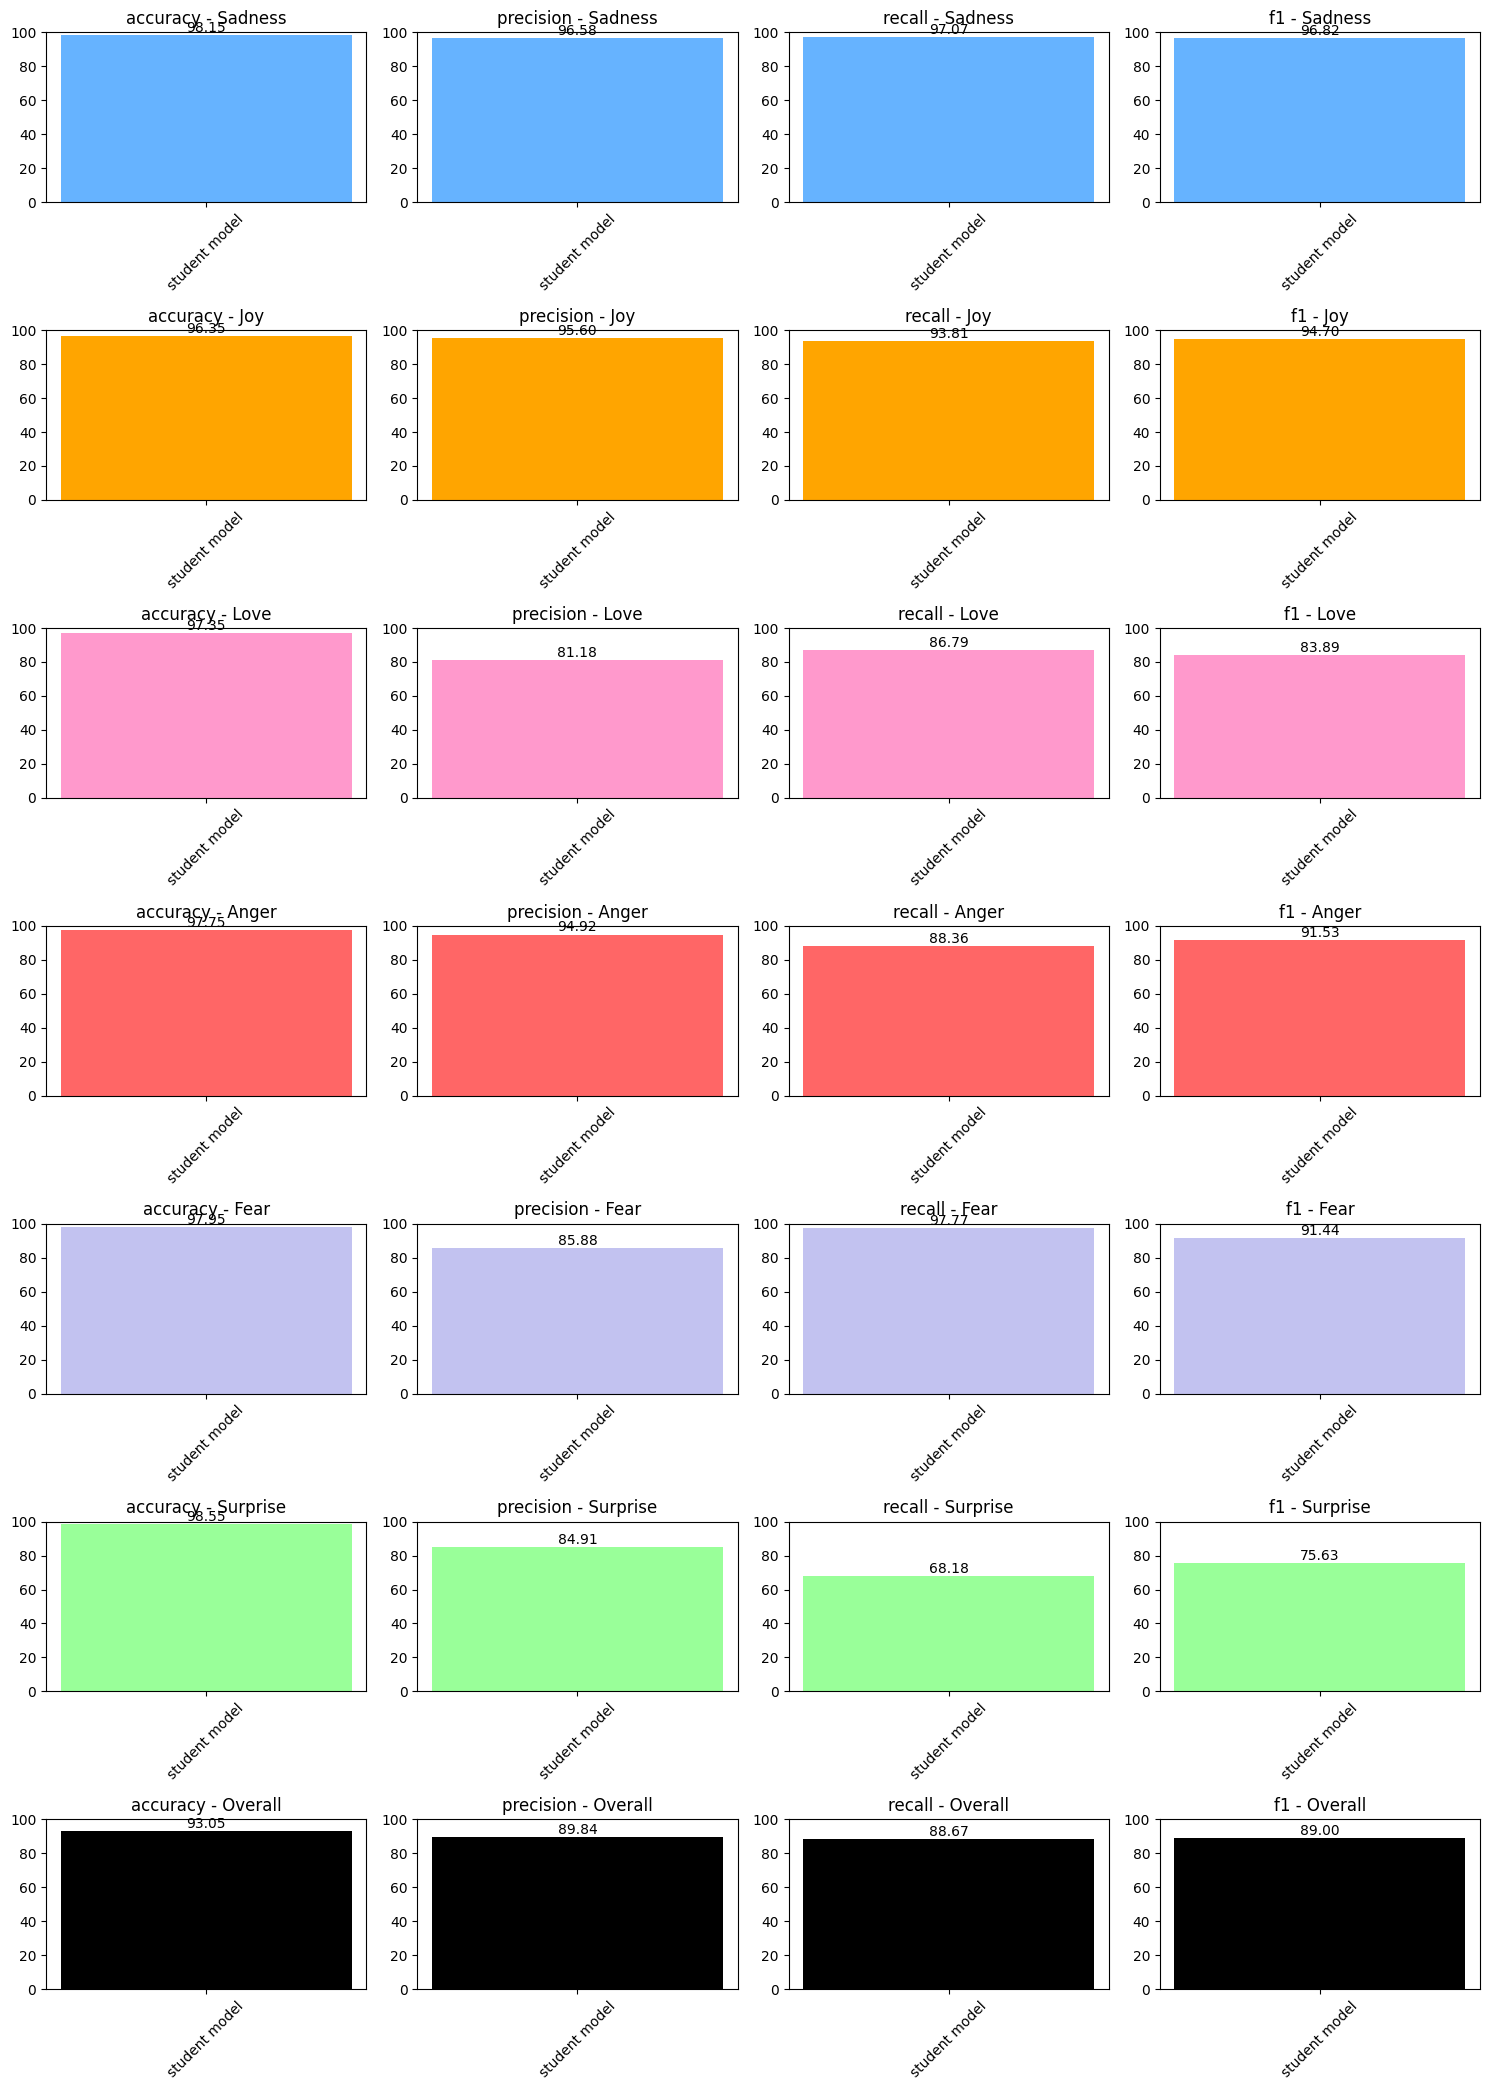

In [19]:
texts = df_test['text'].tolist()
max_length = 64

distiller = Distillation(
    teacher_checkpoint = 'bert-base-uncased', 
    student_checkpoint = 'distilbert-base-uncased', 
    num_labels=6, 
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), 
    path_to_student_weights = path_models_ + "bert_model_weights_100_student_05_10.h5"
)

valid_preds = distiller.predict(texts, max_length)

metrics_val = Metrics()
metrics_val.run(df_test['label'], valid_preds, "student model")
metrics_val.plot_val()

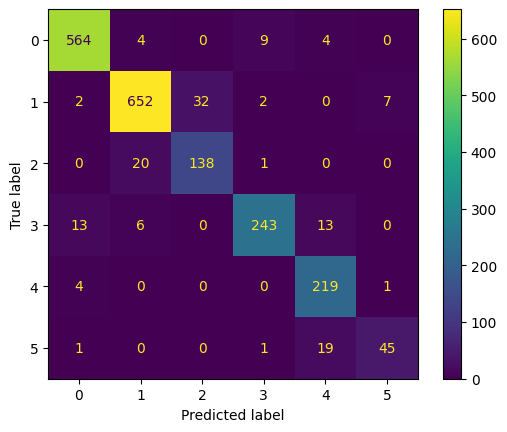

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Now y_true and y_pred are complete, compute the confusion matrix
cm = confusion_matrix(df_test['label'], valid_preds)

#display matrix
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [15]:
predictions =pd.DataFrame({'txt': df_val['text'], 'true': df_val['label'], 'pred': valid_preds})

pred_love_true_joy = predictions[(predictions['true'] == 1) & (predictions['pred'] == 2)]

pred_joy_true_love = predictions[(predictions['true'] == 2) & (predictions['pred'] == 1)]

pred_fear_true_surprise = predictions[(predictions['true'] == 5) & (predictions['pred'] == 4)]

pred_fear_true_anger = predictions[(predictions['true'] == 3) & (predictions['pred'] == 4)]

### 4.c Analysis and Improvements
*Analyze deficiencies in the student model's learning. Suggest potential improvements or further research directions*

In [13]:
import ipywidgets as widgets
from IPython.display import display, Markdown

def review_sentences(sentences):
    current_index = {'index': 0}

    out = widgets.Output()
    progress_label = widgets.Label()

    def update_progress(index):
        progress_label.value = f"Sentence {index+1} of {len(sentences)}" # this shows how far along the sentences we are

    def display_sentence(index):
        with out:
            out.clear_output()
            if index < len(sentences):
                display(Markdown(f'**Sentence:** {sentences[index]}')) # display of sentence
                update_progress(index)
            else:
                display(Markdown("**End of Sentences**")) # message when all sentences have been read

    def on_next_button_clicked(b):
        if current_index['index'] < len(sentences):
            display_sentence(current_index['index'])
            current_index['index'] += 1
        else:
            update_progress(current_index['index'])

    next_button = widgets.Button(description="Next Sentence")
    next_button.on_click(on_next_button_clicked)

    display(progress_label)  # Show progress label above the button
    display_sentence(current_index['index'])  # initial sentence display
    display(next_button, out)

In [14]:
fps_sentences = pred_love_true_joy['txt'].values

review_sentences(fps_sentences) #No need to click "Next Sentence" everytime, click it once, then push the "Enter" button to advance

Label(value='')

Button(description='Next Sentence', style=ButtonStyle())

Output()

In [16]:
fps_sentences = pred_joy_true_love['txt'].values

review_sentences(fps_sentences) #No need to click "Next Sentence" everytime, click it once, then push the "Enter" button to advance

Label(value='')

Button(description='Next Sentence', style=ButtonStyle())

Output()

In [17]:
fps_sentences = pred_fear_true_surprise['txt'].values

review_sentences(fps_sentences) #No need to click "Next Sentence" everytime, click it once, then push the "Enter" button to advance

Label(value='')

Button(description='Next Sentence', style=ButtonStyle())

Output()

In [18]:
fps_sentences = pred_fear_true_anger['txt'].values

review_sentences(fps_sentences) #No need to click "Next Sentence" everytime, click it once, then push the "Enter" button to advance

Label(value='')

Button(description='Next Sentence', style=ButtonStyle())

Output()